In [1]:
#Trying with the wikipedia data set instead


In [61]:
# Step 1: Import Libraries
#Basics
import pandas as pd
import numpy as np
import pickle

#Plots
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
%matplotlib inline

#NLP TOOLS
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwords=stopwords.words('english')


#Strings and regular expressions
import string,re

#Text Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

#Model Building
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

#Evaluation
from sklearn import metrics



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/estherfarkas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/estherfarkas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/estherfarkas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [62]:
#Load the data frame with the csv file to be used
df=pd.read_csv('wiki_movie_plots_deduped.csv')
df.head(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [63]:
#ISBE- Inspect, Select, Build, Evaluate


In [64]:
#Inspect the dataframe- check for null values, duplicates and the breakdowns
df.isnull().sum()


Release Year           0
Title                  0
Origin/Ethnicity       0
Director               0
Cast                1422
Genre                  0
Wiki Page              0
Plot                   0
dtype: int64

In [65]:
df.duplicated().sum()

0

In [66]:
df['Genre'].value_counts()


unknown                                                  6083
drama                                                    5964
comedy                                                   4379
horror                                                   1167
action                                                   1098
                                                         ... 
epic drama set 4,000 years ago in the canadian arctic       1
biography, romantic comedy                                  1
costume social drama                                        1
adventure / family / drama                                  1
fantasy action adventure                                    1
Name: Genre, Length: 2265, dtype: int64

In [67]:
#fix messy column names
df.columns=df.columns.str.replace('/','_')

In [68]:
#remove the non-english titles
df['Origin_Ethnicity'].value_counts()


American        17377
British          3670
Bollywood        2931
Tamil            2599
Telugu           1311
Japanese         1188
Malayalam        1095
Hong Kong         791
Canadian          723
Australian        576
South_Korean      522
Chinese           463
Kannada           444
Bengali           306
Russian           232
Marathi           141
Filipino          128
Bangladeshi        87
Punjabi            84
Turkish            70
Malaysian          70
Egyptian           67
Assamese            9
Maldivian           2
Name: Origin_Ethnicity, dtype: int64

In [69]:
#remove the non-english titles

movie_origin=['American', 'British', 'Australian', 'Canadian']
#df=df['Origin_Ethnicity'].isin(movie_origin)

df.head()
df=df[df.Origin_Ethnicity.isin(movie_origin)]
df.head()
df.Origin_Ethnicity.value_counts()

American      17377
British        3670
Canadian        723
Australian      576
Name: Origin_Ethnicity, dtype: int64

In [70]:
#Maybe Changing the order of the genres will streamline the process
def alphabetize_genre(a_string):
    myGenre=a_string.replace('-', ',').replace('/', ',')
    words=word_tokenize(myGenre)
    words.sort()
    
    for word in words:
        if (word==','):
            words.remove(word)
    myGenre=' '.join(words)
    return myGenre

df['Sorted_genre']=df['Genre'].apply(alphabetize_genre)
print('Original Genre:', df['Genre'][2000])
print('Sorted Genre: ', df['Sorted_genre'][2000])

Original Genre: comedy, musical
Sorted Genre:  comedy musical


In [71]:
df.Sorted_genre.value_counts()

drama                                                     4661
comedy                                                    3849
unknown                                                   1154
horror                                                    1008
western                                                    865
                                                          ... 
concert                                                      1
mystery short                                                1
biographical political thriller                              1
, action horror thriller                                     1
about biodrama canadiens maurice montreal richard star       1
Name: Sorted_genre, Length: 792, dtype: int64

In [72]:
#Changing the value of genre so it only has 1 values
def select_first(a_string):
    words=word_tokenize(a_string)
    
    for word in words:
        if (word==','):
            words.remove(word)
    return words[0]

df['First_Genre']= df['Sorted_genre'].apply(select_first)
print("Original Genre: ", df['Sorted_genre'][2000])
print("First Genre Only: ", df['First_Genre'][2000])

Original Genre:  comedy musical
First Genre Only:  comedy


In [73]:
#df.Sorted_genre.value_counts()
comedy_drama= ['comedy', 'drama']
myCondition= df['First_Genre'].isin(comedy_drama)
df= df[myCondition]



In [74]:
#remove the things that have less than 2 items
df.First_Genre.value_counts()

comedy    5561
drama     5263
Name: First_Genre, dtype: int64

In [75]:
#Select and Engineer features
#Make a pipeline to change the genres
#make lowercase
def make_lowercase(a_string):
    return a_string.lower()

lower_test_string='This IS MY Test String'
lower_test_string=make_lowercase(lower_test_string)
print('Make Lowercase: ' + lower_test_string)

#remove punctuation
def remove_punct(a_string):
    a_string = re.sub(r'[^\w\s]','',a_string)
    return a_string

punct_test_string='Hello!! This is exciting?? No. It, really isnt.'
punct_test_string=remove_punct(punct_test_string)
print('Punctuation Removed: ' +punct_test_string)

#remove stopwords
def remove_stopwords(a_string):
    words=word_tokenize(a_string)
    
    valid_words=[]
    
    for word in words:
        if word not in stopwords:
            valid_words.append(word)
            
    a_string=' '.join(valid_words)
    return a_string

stopwords_test_string='Hey so this is, well its my stopwords test its really neat i guess to me'
stopwords_test_string=remove_stopwords(stopwords_test_string)
print('Remove Stopwords: ' + stopwords_test_string)
    
#Break the words
def stem_the_words(a_string):
    
    porter=PorterStemmer()
    
    words=word_tokenize(a_string)
    
    valid_words=[]
    
    for word in words:
        stemmed_word=porter.stem(word)
        valid_words.append(stemmed_word)
        
    a_string=' '.join(valid_words)
    return a_string

stemwords_test_string='You walked and I walk along the walkway. Walking is fun since we walk together'
stemwords_test_string=stem_the_words(stemwords_test_string)
print('Stemmed: '+ stemwords_test_string)

#Why is it dropping "e"?

Make Lowercase: this is my test string
Punctuation Removed: Hello This is exciting No It really isnt
Remove Stopwords: Hey , well stopwords test really neat guess
Stemmed: you walk and I walk along the walkway . walk is fun sinc we walk togeth


In [76]:
#this is the pipeline so we dont have to type everything a million times
def clean_string_pipeline(a_string):
    a_string=make_lowercase(a_string)
    a_string=remove_punct(a_string)
    a_string=remove_stopwords(a_string)
    
    
    
    return a_string

#sanity check
pipeline_test_string="Hello there! Its a lovely day for a walk, wouldn't you agree Mrs. Smith? I love to garden in my garden. Gardening is so rewarding and you'll agree once you have gardened as well."
pipeline_test_string=clean_string_pipeline(pipeline_test_string)
print('Clean Sentance: '+ pipeline_test_string)
    

Clean Sentance: hello lovely day walk wouldnt agree mrs smith love garden garden gardening rewarding youll agree gardened well


In [ ]:
#apply pipeline to datafram
df['Clean_Plot']=df['Plot'].apply(clean_string_pipeline)

#sanity check
print("Original Text: "+ df['Plot'][20])
print("Cleaned Test: "+ df['Clean_Plot'][20])


In [ ]:
#extracting for word cloud

comedy=df["Genre"]=="comedy"

comedyText=df[comedy].Clean_Plot


text_file = open("comedy.txt", "w")
n = text_file.write(comedyText.to_string())
text_file.close()






In [ ]:
drama=df["Genre"]=="drama"
dramaText=df[drama].Clean_Plot
text_file = open("drama.txt", "w")
n = text_file.write(dramaText.to_string())
text_file.close()

df[drama]

In [ ]:
#Select and Engineer Features
#select X and y

X= df['Clean_Plot'].values
y=df['First_Genre'].values


In [35]:
# Initialize our vectorizer
vectorizer = TfidfVectorizer()

# This makes your vocab matrix
vectorizer.fit(X)

# This transforms your documents into vectors.
X=vectorizer.transform(X)
print(X.shape, type(X))

(10824, 83460) <class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
#Word Cloud Attempt
feature_names=vectorizer.get_feature_names
dense=X.todense()
lst1=dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)
df.T.sum(axis=1)
Cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(df.T.sum(axis=1))

In [20]:
#sanity check
X[0]

<1x83460 sparse matrix of type '<class 'numpy.float64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [21]:
#Build- now we do train test split on our data
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=.20, random_state=20)

#Initialize the model
model=MultinomialNB(alpha=.5)

#fit
model.fit(X_train,y_train)

#test
y_pred=model.predict(X_test)

y_pred_proba= model.predict_proba(X_test)

#check accuracy
accuracy=model.score(X_test, y_test)
print('Model Accuracy: %f' % accuracy)



Model Accuracy: 0.737182


In [22]:
#Check other scores
print(classification_report(y_test, y_pred, target_names=model.classes_))

              precision    recall  f1-score   support

      comedy       0.69      0.88      0.77      1103
       drama       0.82      0.59      0.69      1062

    accuracy                           0.74      2165
   macro avg       0.76      0.73      0.73      2165
weighted avg       0.76      0.74      0.73      2165



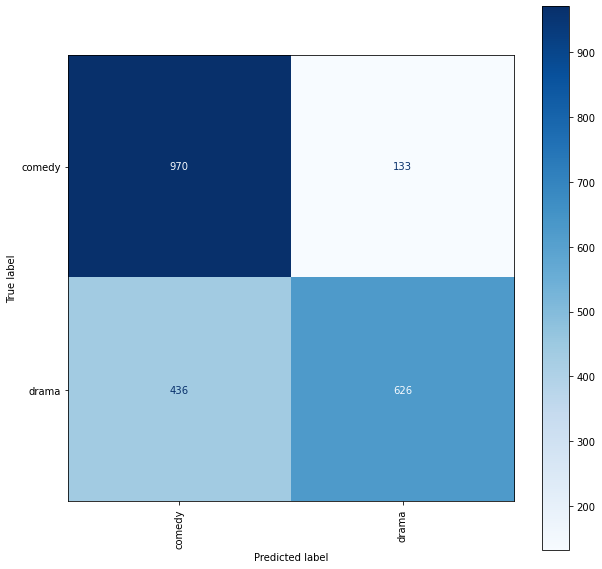

In [42]:
#plot a confusion matrix
fig, ax= plt.subplots(figsize=(10,10))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=model.classes_,
                             cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90)
disp

In [24]:
#pickle
pickle.dump(vectorizer, open('/vectorizer.pkl', ''))

ValueError: Must have exactly one of create/read/write/append mode and at most one plus

In [40]:
#Random Forest Model
rf_model= RandomForestClassifier()

#Fit data
rf_model.fit(X_train, y_train)

#Predctions
y_pred= rf_model.predict(X_test)
y_pred_proba= rf_model.predict_proba(X_test)

#accuracy
accuracy=rf_model.score(X_test,y_test)
print("Model Accuracy: %f" % accuracy)

#Print report
print(classification_report(y_test, y_pred, target_names=rf_model.classes_))



Model Accuracy: 0.727945
              precision    recall  f1-score   support

      comedy       0.71      0.78      0.74      1103
       drama       0.75      0.67      0.71      1062

    accuracy                           0.73      2165
   macro avg       0.73      0.73      0.73      2165
weighted avg       0.73      0.73      0.73      2165



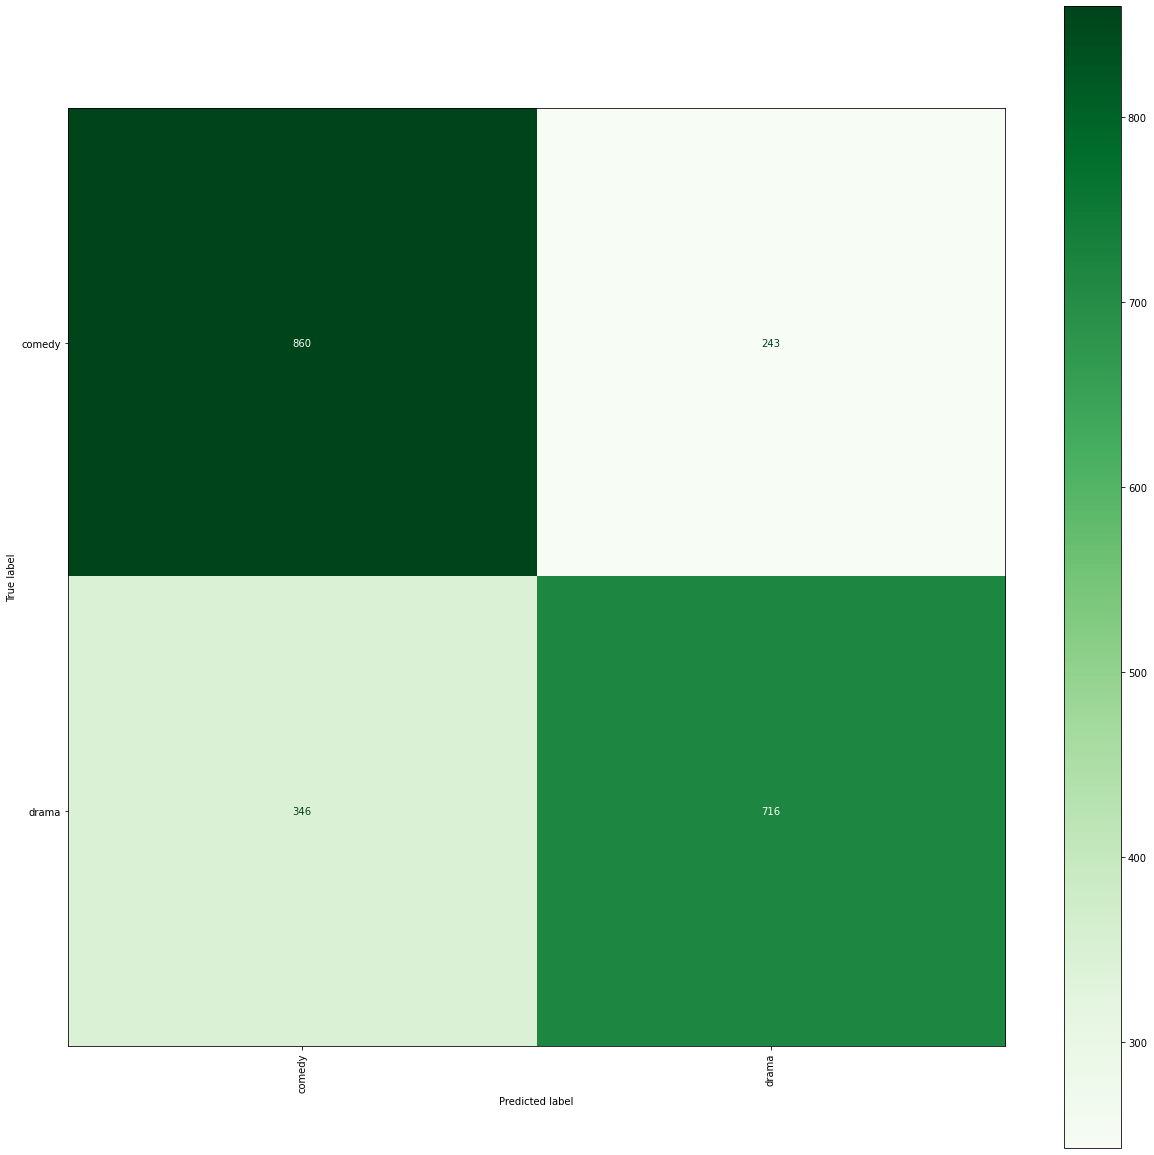

In [41]:
#Display results
# Plot the confusion matrix of our results
fig, ax = plt.subplots(figsize=(21, 21))
disp = plot_confusion_matrix(rf_model, X_test, y_test,
                             display_labels=rf_model.classes_,
                             cmap=plt.cm.Greens, ax=ax)
plt.xticks(rotation=90)
disp
